## Model Training to test [Classification]]
---

In [17]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for 

#Decision Tree Classifier Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [18]:
clean_cc_data = pd.read_excel('check.xlsx')
clean_cc_data.head()

,Country code,Country name,Year,Access to improved sanitation (% of total pop.),Access to improved water source (% of total pop.),CO2 emissions per capita (metric tons),"CO2 emissions per units of GDP (kg/$1,000 of 2005 PPP $)","CO2 emissions, total (KtCO2)",Cereal yield (kg per hectare),"Child malnutrition, underweight (% of under age 5)",Energy use per capita (kilograms of oil equivalent),"Energy use per units of GDP (kg oil eq./$1,000 of 2005 PPP $)","Foreign direct investment, net inflows (% of GDP)",GDP ($),GHG net emissions/removals by LUCF (MtCO2e),GNI per capita (Atlas $),Invest. in energy w/ private participation ($),Invest. in telecoms w/ private participation ($),Invest. in transport w/ private participation ($),Invest. in water/sanit. w/ private participation ($),Nationally terrestrial protected areas (% of total land area),Paved roads (% of total roads),"Physicians (per 1,000 people)",Population,Population growth (annual %),Population in urban agglomerations >1million (%),Population living below $1.25 a day (% of total),"Primary completion rate, total (% of relevant age group)",Ratio of girls to boys in primary & secondary school (%),"Under-five mortality rate (per 1,000)",Urban population,Urban population growth (annual %)
0,ARG,Argentina,1990,90.0,94.0,3.449913,462.560560,112613.570,2232.2,1.7,1411.466520,189.247912,1.298882,1.413524e+11,-43.2979,3180,5.023150e+09,1254700000,2.088000e+09,7.500000e+07,4.587644,28.500000,2.680000,32642442.0,1.404532,39.204392,0.13,100.0,100.0,26.9,2.839892e+07,1.865363
1,ARG,Argentina,1991,90.2,94.2,3.536073,426.614517,117021.304,2666.1,1.7,1434.960601,173.122857,1.285579,1.897200e+11,-43.2979,3960,5.023150e+09,2648000000,2.140000e+08,7.500000e+07,4.772468,28.500000,2.682000,33093579.0,1.372593,39.119646,0.13,100.0,100.0,25.8,2.890393e+07,1.762636
2,ARG,Argentina,1992,90.4,94.4,3.620969,395.521880,121447.373,3057.3,1.7,1489.450708,162.694128,1.936791,2.287794e+11,-43.2979,6300,5.023150e+09,1111000000,8.147000e+08,0.000000e+00,5.060855,28.500000,2.684000,33540023.0,1.340017,39.042135,0.13,100.0,100.0,24.9,2.940789e+07,1.728544
3,ARG,Argentina,1993,90.6,94.6,3.490348,364.733889,118609.115,2846.5,1.7,1469.434276,153.552751,1.179744,2.367536e+11,-43.2979,7100,2.494840e+09,2095000000,1.439600e+09,4.000000e+09,5.156290,28.600000,2.682667,33982035.0,1.309256,38.975668,0.49,100.0,100.0,24.2,2.991099e+07,1.696280
4,ARG,Argentina,1994,90.8,94.8,3.583651,358.397431,123350.546,2815.9,1.7,1552.459429,155.259927,1.411953,2.574400e+11,-43.2979,7570,2.075680e+09,2170000000,9.405000e+08,1.900000e+06,5.235386,28.700001,2.681333,34420352.0,1.281601,38.920819,0.85,100.0,100.0,23.4,3.041382e+07,1.667133


In [19]:
pd.set_option('display.max_columns', None)

clean_cc_data.info(32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 32 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Country code                                                   210 non-null    object 
 1   Country name                                                   210 non-null    object 
 2   Year                                                           210 non-null    int64  
 3   Access to improved sanitation (% of total pop.)                210 non-null    float64
 4   Access to improved water source (% of total pop.)              189 non-null    float64
 5   CO2 emissions per capita (metric tons)                         210 non-null    float64
 6   CO2 emissions per units of GDP (kg/$1,000 of 2005 PPP $)       210 non-null    float64
 7   CO2 emissions, total (KtCO2)                                  

Creating a Standard of Living Index
with these variables

| Education | Health | Income |
|---|---|---|
| Primary completion rate 0.15 | Under-five mortality 0.15 | GNI per capita 0.15 |
|                              | Physicians per 1,000 0.10 | Poverty rate 0.10 |

<br/>

| Infrastructure | Urbanization | Basic Services |
|---|---|---|
| Paved roads 0.10 | Urban population 0.05 | Improved water 0.10     |
|                  |                       | Improved sanitation 0.10 |




Example of weighting which is more important then the formula can be (data x weight) then add up all to standard of living/1

In [20]:
#Creating DataFrames for all the variables to create the Standard of Living Index

s1 = pd.DataFrame(clean_cc_data['Primary completion rate, total (% of relevant age group)'])
s2 = pd.DataFrame(clean_cc_data['Under-five mortality rate (per 1,000)'])
s3 = pd.DataFrame(clean_cc_data['Physicians (per 1,000 people)'])
s4 = pd.DataFrame(clean_cc_data['GNI per capita (Atlas $)'])
s5 = pd.DataFrame(clean_cc_data['Population living below $1.25 a day (% of total)'])
s6 = pd.DataFrame(clean_cc_data['Paved roads (% of total roads)'])
s7 = pd.DataFrame(clean_cc_data['Urban population'])
s8 = pd.DataFrame(clean_cc_data['Access to improved sanitation (% of total pop.)'])
s9 = pd.DataFrame(clean_cc_data['Access to improved water source (% of total pop.)'])

These are the formulas used to calculate our standard of living

| Primary completion rate (%) | Under-five mortality rate (/1000) | Physicians per 1,000 | GNI per capita |
|---|---|---|---|
| $E = e/100$ | $H = 1 - M/Mmax$ | $P = p/Max p$ | $I = i/100$ |

<br/>

| Population below $1.25/day (%) | Paved roads (%) | Urban population (%) | Improved water(%) | 
|---|---|---|---|
| $Pov = 1 - pov/100$ | $R = r/100$ | $U = u/100$ | $W = w/100$ | 

<br/>
Improved sanitation (%) <br/>
$S = s/100$

In [21]:
# compute Standard of Living components and per-country averages

# detect country column
possible_country_cols = [c for c in clean_cc_data.columns if c.lower().startswith('country')]
if not possible_country_cols:
    raise KeyError("No country column found. Ensure a column starting with 'Country' exists.")
country_col = possible_country_cols[0]

# columns used for SOL (use exact names present in the notebook)
sol_cols = {
    'Primary completion rate, total (% of relevant age group)': 'primary',
    'Under-five mortality rate (per 1,000)': 'under5',
    'Physicians (per 1,000 people)': 'physicians',
    'GNI per capita (Atlas $)': 'gni',
    'Population living below $1.25 a day (% of total)': 'poverty',
    'Paved roads (% of total roads)': 'paved_roads',
    'Urban population': 'urban_pop',
    'Access to improved sanitation (% of total pop.)': 'sanitation',
    'Access to improved water source (% of total pop.)': 'water'
}

# ensure columns exist
missing = [c for c in sol_cols.keys() if c not in clean_cc_data.columns]
if missing:
    raise KeyError(f"Missing required columns for SOL calculation: {missing}")

# compute per-country mean of the metrics (numeric only)
country_means = clean_cc_data.groupby(country_col)[list(sol_cols.keys())].mean().reset_index()
country_means = country_means.rename(columns=sol_cols)

# compute normalization denominators (use dataset-level max to keep consistent scale)
# avoid zero division by replacing 0 with nan then fallback to 1
mort_max = country_means['under5'].replace(0, np.nan).max()
phys_max = country_means['physicians'].replace(0, np.nan).max()
mort_max = mort_max if pd.notna(mort_max) else 1.0
phys_max = phys_max if pd.notna(phys_max) else 1.0

# compute SOL components
country_means['E_primary'] = country_means['primary'] / 100.0
country_means['H_under5'] = 1.0 - (country_means['under5'] / mort_max)
country_means['P_physicians'] = country_means['physicians'] / phys_max
country_means['I_gni'] = country_means['gni'] / 100.0
country_means['Pov_not'] = 1.0 - (country_means['poverty'] / 100.0)
country_means['R_roads'] = country_means['paved_roads'] / 100.0
country_means['U_urban'] = country_means['urban_pop'] / 100.0
country_means['W_water'] = country_means['water'] / 100.0
country_means['S_sanitation'] = country_means['sanitation'] / 100.0

# clamp to [0,1]
comp_cols = ['E_primary','H_under5','P_physicians','I_gni','Pov_not','R_roads','U_urban','W_water','S_sanitation']
country_means[comp_cols] = country_means[comp_cols].clip(0.0,1.0)

# weights
weights = {
    'E_primary': 0.15,
    'H_under5': 0.15,
    'I_gni': 0.15,
    'P_physicians': 0.10,
    'Pov_not': 0.10,
    'R_roads': 0.10,
    'U_urban': 0.05,
    'W_water': 0.10,
    'S_sanitation': 0.10
}

# weighted SOL index
country_means['SOL_index'] = sum(country_means[c]*w for c,w in weights.items())

# merge SOL back to main dataframe (country-level SOL)
clean_cc_data = clean_cc_data.merge(country_means[[country_col,'SOL_index']], on=country_col, how='left')

# display results
print("Country-level SOL (top rows):")
print(country_means[[country_col,'SOL_index']].info())
print("\nSOL index summary:")
print(country_means['SOL_index'].describe())

# optional: save results
# country_means.to_csv('country_SOL_index.csv', index=False)
# ...existing code...

Country-level SOL (top rows):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country code  10 non-null     object 
 1   SOL_index     9 non-null      float64
dtypes: float64(1), object(1)
memory usage: 292.0+ bytes
None

SOL index summary:
count    9.000000
mean     0.771831
std      0.115882
min      0.546992
25%      0.743377
50%      0.801540
75%      0.858185
max      0.907088
Name: SOL_index, dtype: float64


Partition the dataset given randomly into Train and Test datasets – 70% for Train and 30% for Test. 

On the Train set, fit three uni-variate Decision Tree models for Alcohol against each of the three numeric variables, with max_depth = 2. 

For each such tree model, print the classification accuracy of the model you fit. 

Also compute the Precision and Recall scores for both train and test datasets.

In [ ]:
X1 = pd.DataFrame(clean_cc_data['Energy use per units of GDP (kg oil eq./$1,000 of 2005 PPP $)'])
X2 = pd.DataFrame(clean_cc_data['CO2 emissions per units of GDP (kg/$1,000 of 2005 PPP $)'])
X3 = pd.DataFrame(clean_cc_data['GHG net emissions/removals by LUCF (MtCO2e)'])
y = pd.DataFrame(clean_cc_data['SOL_index'])
y=y.astype('str')
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size = 0.3)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.3)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size = 0.3)

print('X1 Train Data: ', X1_train.shape, y_train.shape)
print('X1 Test Data: ', X1_test.shape, y_test.shape)
print('X2 Train Data: ', X2_train.shape, y_train.shape)
print('X2 Test Data: ', X2_test.shape, y_test.shape)
print('X3 Train Data: ', X3_train.shape, y_train.shape)
print('X3 Test Data: ', X3_test.shape, y_test.shape)

X1 Train Data:  (147, 1) (147, 1)
X1 Test Data:  (63, 1) (63, 1)
X2 Train Data:  (147, 1) (147, 1)
X2 Test Data:  (63, 1) (63, 1)
X3 Train Data:  (147, 1) (147, 1)
X3 Test Data:  (63, 1) (63, 1)


In [23]:
DT1 = DecisionTreeClassifier(max_depth = 2)
DT2 = DecisionTreeClassifier(max_depth = 2)
DT3 = DecisionTreeClassifier(max_depth = 2)
DT1.fit(X = X1_train, y = y_train)
DT2.fit(X = X2_train, y = y_train)
DT3.fit(X = X3_train, y = y_train)

DecisionTreeClassifier(max_depth=2)

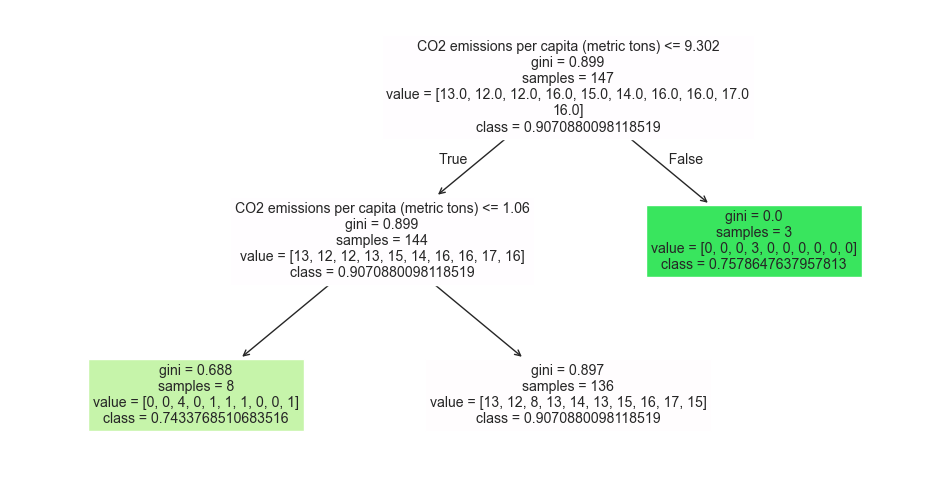

In [24]:
plt.figure(figsize=(12,6))
plot_tree(DT1, filled = True, feature_names = DT1.feature_names_in_, class_names = DT1.classes_);

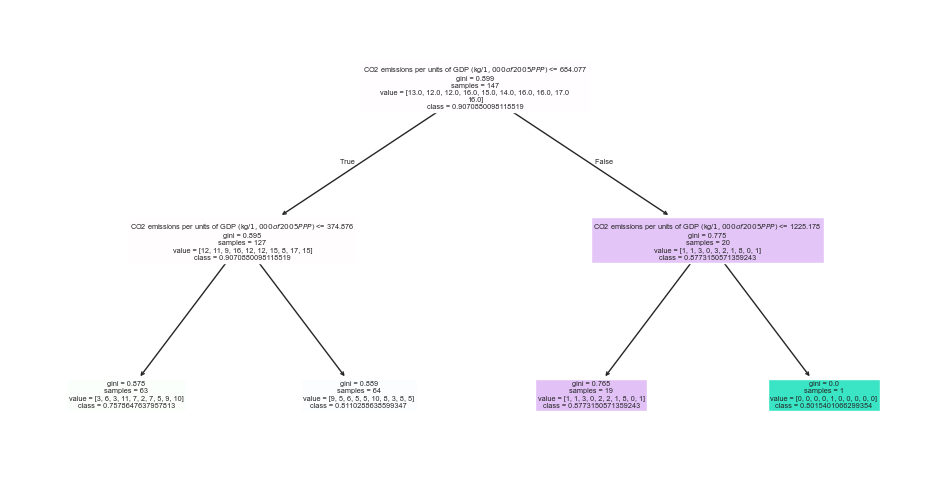

In [25]:
plt.figure(figsize=(12,6))
plot_tree(DT2, filled = True, feature_names = DT2.feature_names_in_, class_names = DT2.classes_);

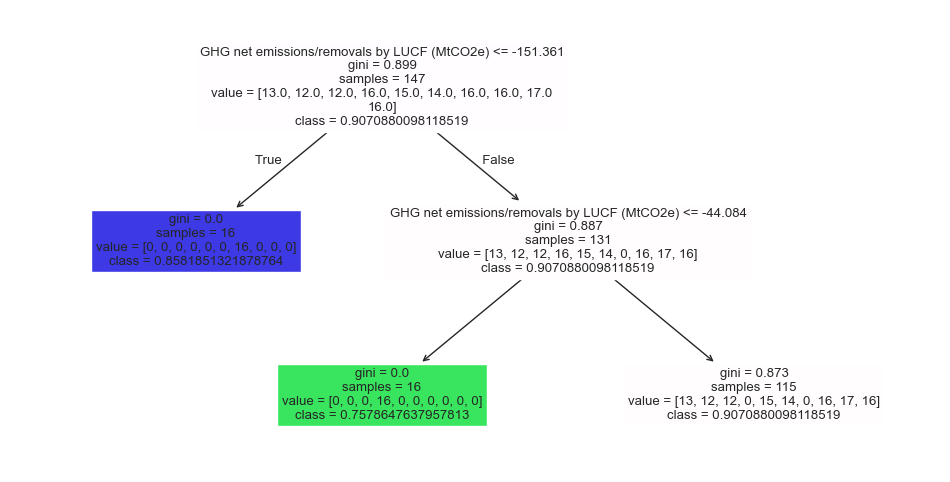

In [26]:
plt.figure(figsize=(12,6))
plot_tree(DT3, filled = True, feature_names = DT3.feature_names_in_, class_names = DT3.classes_);

<Axes: >

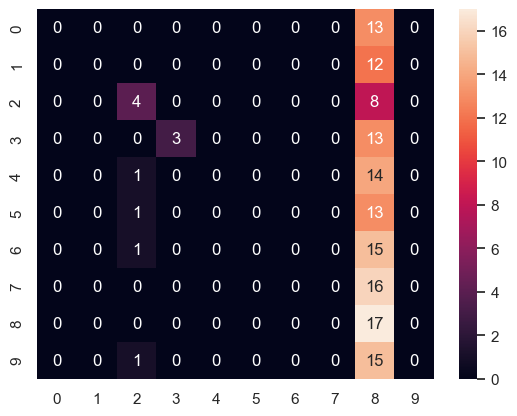

In [27]:
y1_train_pred = DT1.predict(X1_train)
sb.heatmap(confusion_matrix(y_train, y1_train_pred), annot = True)

CO2 Emission per capita

<Axes: >

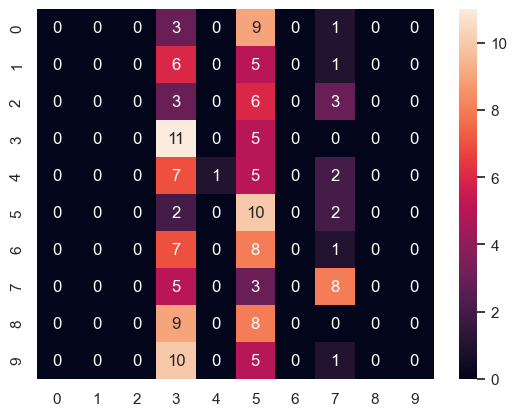

In [28]:
y2_train_pred = DT2.predict(X2_train)
sb.heatmap(confusion_matrix(y_train, y2_train_pred), annot = True)

CO2 Emission per gdp

<Axes: >

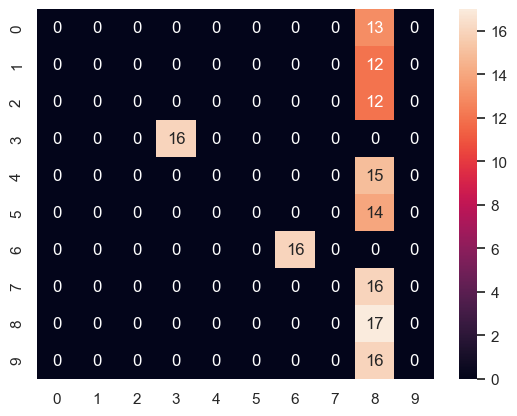

In [29]:
y3_train_pred = DT3.predict(X3_train)
sb.heatmap(confusion_matrix(y_train, y3_train_pred), annot = True)

GNG net emissions

In [30]:
CM1 = confusion_matrix(y_train, y1_train_pred)

TP = CM1[1][1]
TN = CM1[0][0]
FP = CM1[0][1]
FN = CM1[1][0]

P = TP / (TP + FP)
R = TP / (TP + FN)

print("Train Classification Accuracy \t:", DT1.score(X1_train, y_train))
print("Precision:", P)
print("Recall:", R)

Train Classification Accuracy 	: 0.16326530612244897
Precision: nan
Recall: nan


C:\Users\Winston James\AppData\Local\Temp\ipykernel_5600\2336841906.py:8: RuntimeWarning: invalid value encountered in scalar divide
  P = TP / (TP + FP)
C:\Users\Winston James\AppData\Local\Temp\ipykernel_5600\2336841906.py:9: RuntimeWarning: invalid value encountered in scalar divide
  R = TP / (TP + FN)


In [31]:
CM2 = confusion_matrix(y_train, y2_train_pred)

TP = CM2[1][1]
TN = CM2[0][0]
FP = CM2[0][1]
FN = CM2[1][0]

P = TP / (TP + FP)
R = TP / (TP + FN)

print("Train Classification Accuracy \t:", DT2.score(X2_train, y_train))
print("Precision:", P)
print("Recall:", R)

Train Classification Accuracy 	: 0.20408163265306123
Precision: nan
Recall: nan


C:\Users\Winston James\AppData\Local\Temp\ipykernel_5600\1836458270.py:8: RuntimeWarning: invalid value encountered in scalar divide
  P = TP / (TP + FP)
C:\Users\Winston James\AppData\Local\Temp\ipykernel_5600\1836458270.py:9: RuntimeWarning: invalid value encountered in scalar divide
  R = TP / (TP + FN)


In [32]:
CM3 = confusion_matrix(y_train, y3_train_pred)

TP = CM3[1][1]
TN = CM3[0][0]
FP = CM3[0][1]
FN = CM3[1][0]

P = TP / (TP + FP)
R = TP / (TP + FN)

print("Train Classification Accuracy \t:", DT3.score(X3_train, y_train))
print("Precision:", P)
print("Recall:", R)

Train Classification Accuracy 	: 0.3333333333333333
Precision: nan
Recall: nan


C:\Users\Winston James\AppData\Local\Temp\ipykernel_5600\2633334761.py:8: RuntimeWarning: invalid value encountered in scalar divide
  P = TP / (TP + FP)
C:\Users\Winston James\AppData\Local\Temp\ipykernel_5600\2633334761.py:9: RuntimeWarning: invalid value encountered in scalar divide
  R = TP / (TP + FN)
